## **LunarLander con Neuroevolución**
Entrenamiento de una red neuronal mediante Computación Evolutiva. Se hace uso de un Algoritmo Genético Evolucional. Se evolucionan los pesos de la red. Un individuo tiene X cromosomas, cada uno de ellos representa un peso del modelo, con una arquitectura interna de capas [8,X,4].

El fitness un agente es el refuerzo acumulativo de una partida LunarLander. Como el entorno es cambiante, para cada individuo se entrenan varios escenarios, y se toma como refuerzo el promedio.

In [1]:
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="rgb_array")

import numpy as np
import pygame
import gymnasium.utils.play
from MLP import MLP
import random
import loky
from loky import get_reusable_executor
import itertools
import multiprocessing
import time
import matplotlib.pyplot as plt
import pickle
from gymnasium.wrappers import RecordVideo

%matplotlib inline

lunar_lander_keys = {
    (pygame.K_UP,): 2,
    (pygame.K_LEFT,): 1,
    (pygame.K_RIGHT,): 3,
}

print(f"Nucleos: {multiprocessing.cpu_count()}")

Nucleos: 40


### Tareas
1. Probar nuevas politicas
2. Nuevos operadores: crossover, mutacion
3. Cambio de arquitectura [8, X, 4]. 2,6,20
4. Graficas: 
    - mejor fitness en funcion de generaciones
    - fitness medio (de poblacion) en funcion de generaciones
    - Precision (numero de aterrizajes correctos en cada iteracion) // hay que obtener "algun indicativo de que aterrice bien" 

## **Algoritmo Genético**

**Políticas y run()**

In [2]:
def policy_base (observation, model):
    s = model.forward(observation)
    action = np.argmax(s)
    return action


def policy_epsGreedy(observation, model):
    epsilon = 0.10
    s = model.forward(observation)
    if np.random.rand() < epsilon:
        action = np.random.randint(len(s))
    else:
        action = np.argmax(s)
    return action



def run (model):
    observation, info = env.reset()
    ite = 0
    racum = 0
    while True:
        action = policy_epsGreedy(observation, model)
        observation, reward, terminated, truncated, info = env.step(action)
        
        racum += reward

        if terminated or truncated:
            return racum


def run_multiple_games(ch, arquitecture, N_games):

    model = MLP(arquitecture)
    model.from_chromosome(ch)

    r = 0

    for _ in range(N_games):
        r += run(model)
    
    return r/N_games 

**Mutate**

In [3]:
def mutate(ind, pmut, rang):
    if random.random() < pmut:
        for i in range(len(ind)):
            ind[i] = random.uniform(rang[0], rang[1])
    return ind.copy()


def mutate_gaussian_normal(ind, pmut, mutation_power=0.002):
    if random.random() < pmut:
        for i in range(len(ind)):
            # distribución normal
            noise = np.random.normal(0, mutation_power)  # Media = 0, desviación estándar = mutation_power
            ind[i] += noise
        return ind.copy()
    else:
        return ind.copy()


def mutate_gaussian_uniforme(ind, pmut):
    if random.random() < pmut:
        ind = [gen + random.uniform(-1, 1) for gen in ind]
    return ind.copy()


**Crossovers**

In [4]:
def crossover_lineal (ind1, ind2, pcross, arquitecture): # devuelve el cruce (emparejamiento) de dos individuos, considerando todos los genes
    if (random.random() > pcross):
        return ind1.copy(), ind2.copy()
    child1 = []
    child2 = []

    for gene1, gene2 in zip(ind1, ind2):
        beta = random.uniform(0, 1)
        c1 = beta * gene1 + (1 - beta) * gene2
        c2 = (1 - beta) * gene1 + beta * gene2
        
        child1.append(c1)
        child2.append(c2)
    
    return child1, child2

def crossover_alpha(parent1, parent2, pcross):
    
    alpha = 0.5
    if random.random() < pcross:
        child1 = []
        child2 = []
        for gene1, gene2 in zip(parent1, parent2):
            
            x_min = min(gene1, gene2)
            x_max = max(gene1, gene2)
            I = x_max - x_min
       
            lower_bound = x_min - alpha * I
            upper_bound = x_max + alpha * I
      
            c1 = random.uniform(lower_bound, upper_bound)
            c2 = random.uniform(lower_bound, upper_bound)
            child1.append(c1)
            child2.append(c2)

        return child1, child2
    else:
        return parent1, parent2



def crossover_blending(ind1, ind2, pcross, alpha=0.5):
    
    if random.random() > pcross:
        return ind1.copy(), ind2.copy()
    
    child1 = []
    child2 = []

    for gene1, gene2 in zip(ind1, ind2):
        beta = random.uniform(-alpha, 1 + alpha)  
        c1 = beta * gene1 + (1 - beta) * gene2
        c2 = beta * gene2 + (1 - beta) * gene1
        
        child1.append(c1)
        child2.append(c2)

    return child1, child2



In [5]:
rang = (-5, 5)
createRang = (-5, 5)

def select(pop, T, fitness_array): 
    tournament = random.sample(range(len(pop)), T)  
    best_index = max(tournament, key=lambda i: fitness_array[i])  
    return pop[best_index].copy()  


def create(createRang, arquitecture, N=100): 
    pop = []
    
    print(f"--- Creacion de poblacion: Individuos = {100}, Rango = {createRang}")

    cromosoma_length = (arquitecture[0] * arquitecture[1]) + arquitecture[1] + (arquitecture[1] * arquitecture[2]) + arquitecture[2]

    for _ in range(N):
        values = [random.uniform(createRang[0], createRang[1]) for _ in range(cromosoma_length)]  
        pop.append(values)

    return pop


def sort_pop (pop, fitness): 

    aux_pop = pop
    aux_fitness = fitness

    pop_with_fitness = [(indiv, fit) for indiv, fit in zip(aux_pop, aux_fitness)]
    sorted_pop = sorted(pop_with_fitness, key=lambda x: x[1], reverse=True)  
    return [indiv for indiv, _ in sorted_pop], [fit for _, fit in sorted_pop]

    


def evolve_gen(pop, rangMut, pmut, mutation_power, arquitecture = [8,6,4], generations = 6000, T=2, trace=100, pcross=0.7, elitism=False, N_games=2, n_elitism=0):
    
    print(f"Parámetros: pmut = {pmut}, Rango de Mutacion = {rangMut}, arquitecture = {arquitecture}, generations = {generations}, T = {T}, pcross = {pcross}, elitism = {elitism}, N_games = {N_games}, n_elitism = {n_elitism}")
    
    max_fitness_perGeneration = []
    mean_fitness_perGeneration = []
    min_fitness_perGeneration = []

    generation = 0
    executor = get_reusable_executor(max_workers=8)

    
    while generation < generations:
        new_poblacion = []

        fitness_array = list(executor.map(run_multiple_games, pop, itertools.repeat(arquitecture), itertools.repeat(N_games)))
        generation += 1

        pop, fitness = sort_pop(pop, fitness_array)
     

        max_fitness_perGeneration.append(fitness[0])
        mean_fitness_perGeneration.append(np.array(fitness).mean())
        min_fitness_perGeneration.append(fitness[-1])

        if trace > 0 and generation % trace == 0:
            print(f"Generacion: {generation}, Mejor fitness: {fitness[0]}")
            
        if generation >= generations:
            break

        if elitism:
            new_poblacion.extend([ind.copy() for ind in pop[:n_elitism]])

        while len(new_poblacion) < len(pop):
            parent_1 = select(pop, T, fitness)
            parent_2 = select(pop, T, fitness)

            child_1, child_2 = crossover_blending(parent_1, parent_2, pcross)

            m1 = mutate_gaussian_uniforme(child_1, pmut)
            m2 = mutate_gaussian_uniforme(child_2, pmut)

            new_poblacion.extend([m1, m2])

        pop = new_poblacion[:len(pop)].copy()

    print(f"Generacion: {generation}, Mejor fitness: {fitness[0]}")
    
    return pop, fitness, max_fitness_perGeneration, mean_fitness_perGeneration, min_fitness_perGeneration


### **Prueba 1**

**Configuracion**:
- Crossover Lineal 
- Mutación gaussiana con distribucion Normal. Mutation_power = 0.2. El 70% del ruido estará en el rango (-0.2, 0.2) Probabilidad de mutación = 0.1
- Política: epsilon greedy con epsilon = 0.1
- 1000 generaciones
- Elitismo con n_elitism = 5

In [ ]:
best_individuals = []
fitness_values = []

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. mutate gaussiano 1 con un 0.2")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_min, f_mean = evolve_gen(pop, rangMutacion, pmut=0.1, arquitecture=[8,6,4], generations=1000, T=8, trace=50, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    # Almacenar resultados
    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

Ejecución 1
Politica: eps_greedy con 0.1. mutate gaussiano 1
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 1000, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 50, Mejor fitness: 35.44676429606502
Generacion: 100, Mejor fitness: 31.96727883700095
Generacion: 150, Mejor fitness: 77.67674347371837
Generacion: 200, Mejor fitness: 149.68569329361395
Generacion: 250, Mejor fitness: 163.4644302568507
Generacion: 300, Mejor fitness: 153.92880372849655
Generacion: 350, Mejor fitness: 153.56635495328422
Generacion: 400, Mejor fitness: 173.11246056759626
Generacion: 450, Mejor fitness: 162.0995254050241
Generacion: 500, Mejor fitness: 156.9085126690114
Generacion: 550, Mejor fitness: 270.31772645258417
Generacion: 600, Mejor fitness: 162.19891105723715
Generacion: 650, Mejor fitness: 251.40935427932422
Generacion: 700, Mejor fitness: 179.27604003020147
Generaci

#### **Prueba 1.1**

Prueba de valores de la mutacion gaussiana con distribución normal:
- Valores: 0.002: 0.02, 0.2, 0.5.

In [ ]:
import pickle

best_individuals = []
fitness_values = []

f_maxs = []
f_mins = []
f_means = []

mutation_power = [0.002, 0.02, 0.2, 0.5]

execution_times = []

for i, m_p in enumerate(mutation_power):

    start_time = time.time()

    print(f"### Entrenamiento [{i}]. Mutation_power: {m_p}")  

    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_mean, f_min = evolve_gen(pop, rangMutacion, pmut=0.1, mutation_power=m_p, arquitecture=[8,6,4], generations=1000, T=8, trace=200, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
                 
    f_maxs.append(list(f_max))  
    f_mins.append(list(f_min))
    f_means.append(list(f_mean))

    best_individuals.append(list(pop))  
    fitness_values.append(list(fitness))  

    end_time = time.time()
    execution_times.append((end_time - start_time)/60)

    # Guardar los datos en el archivo después de cada iteración
    with open("resultados_AG_mutation_power_1.1.pkl", "wb") as f:
        pickle.dump({
            "best_individuals": best_individuals,
            "fitness_values": fitness_values,
            "f_maxs": f_maxs,
            "f_mins": f_mins,
            "f_means": f_means,
            "execution_times": execution_times
        }, f)

    print(f"Iteración [{i}] completada y guardada en 'resultados_AG_mutation_power.pkl'")


### Entrenamiento [0]. Mutation_power: 0.002
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 1000, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 200, Mejor fitness: 6.691085520025486
Generacion: 400, Mejor fitness: -20.338049817732326
Generacion: 600, Mejor fitness: 3.3193204709902537
Generacion: 800, Mejor fitness: 42.75761149804723
Generacion: 1000, Mejor fitness: -7.857960041482964
Generacion: 1000, Mejor fitness: -7.857960041482964
Iteración [0] completada y guardada en 'resultados_mutation_power.pkl'
### Entrenamiento [1]. Mutation_power: 0.02
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 1000, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 200, Mejor fitness: -44.23069895256725
Generacion: 400, Mejor fitness: -3

In [ ]:
with open("resultados_AG_mutation_power_1.1.pkl", "rb") as f:
    data = pickle.load(f)

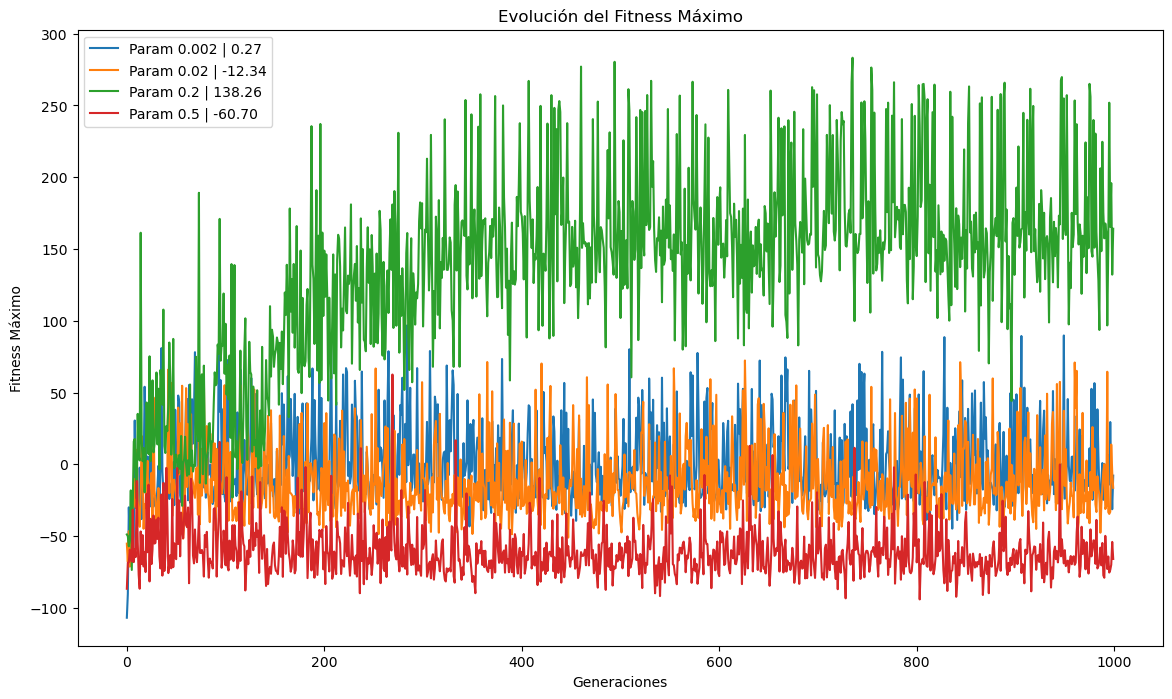

In [71]:
import pickle
import matplotlib.pyplot as plt

mutation_power = [0.002, 0.02, 0.2, 0.5]

f_maxs = data["f_maxs"]
f_mins = data["f_mins"]
f_means = data["f_means"]
execution_times = data["execution_times"]

plt.figure(figsize=(14,8))
for i, f_max in enumerate(f_maxs):
    plt.plot(f_max, label=f"Param {mutation_power[i]} | {np.array(f_max).mean():.2f}")


plt.xlabel("Generaciones")
plt.ylabel("Fitness Máximo")
plt.title("Evolución del Fitness Máximo")
plt.legend()
plt.show()


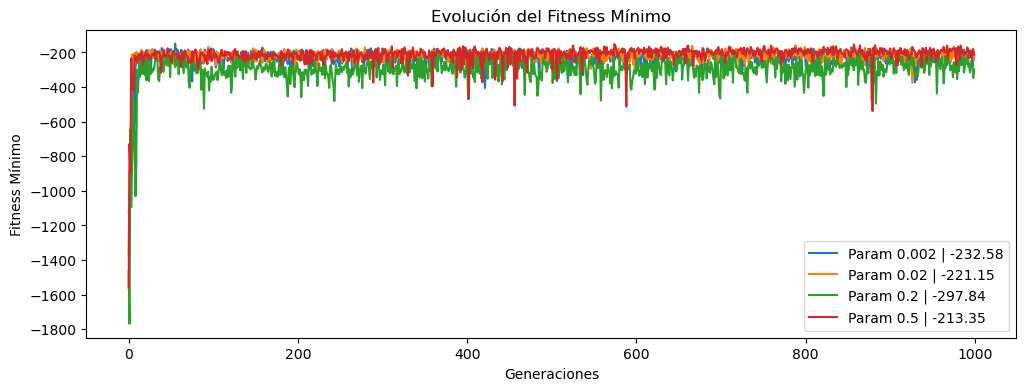

In [56]:
mutation_power = [0.002, 0.02, 0.2, 0.5]

f_maxs = data["f_maxs"]
f_mins = data["f_mins"]
f_means = data["f_means"]
execution_times = data["execution_times"]

plt.figure(figsize=(12,4))
for i, f_min in enumerate(f_mins):
    plt.plot(f_min, label=f"Param {mutation_power[i]} | {np.array(f_min).mean():.2f}")


plt.xlabel("Generaciones")
plt.ylabel("Fitness Mínimo")
plt.title("Evolución del Fitness Mínimo")
plt.legend()
plt.show()

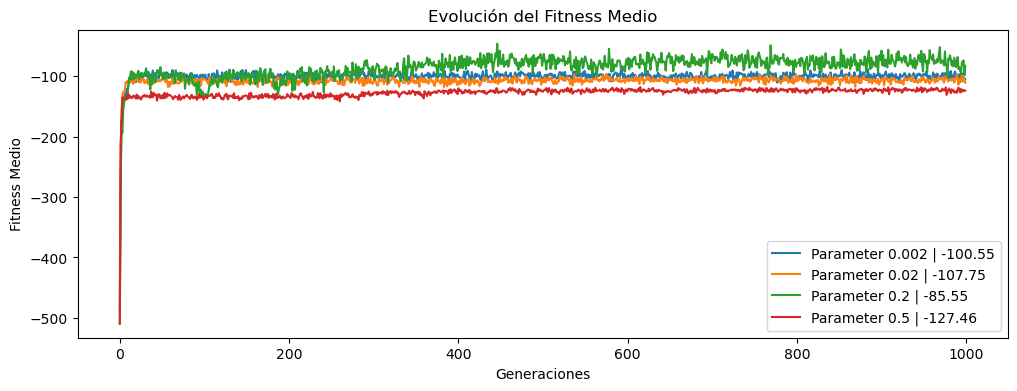

In [57]:
mutation_power = [0.002, 0.02, 0.2, 0.5]

f_maxs = data["f_maxs"]
f_mins = data["f_mins"]
f_means = data["f_means"]
execution_times = data["execution_times"]

plt.figure(figsize=(12,4))
for i, f_mean in enumerate(f_means):
    plt.plot(f_mean, label=f"Parameter {mutation_power[i]} | {np.array(f_mean).mean():.2f}")


plt.xlabel("Generaciones")
plt.ylabel("Fitness Medio")
plt.title("Evolución del Fitness Medio")
plt.legend()
plt.show()

#### **Plot** del resultado con mutation_power = 0.2

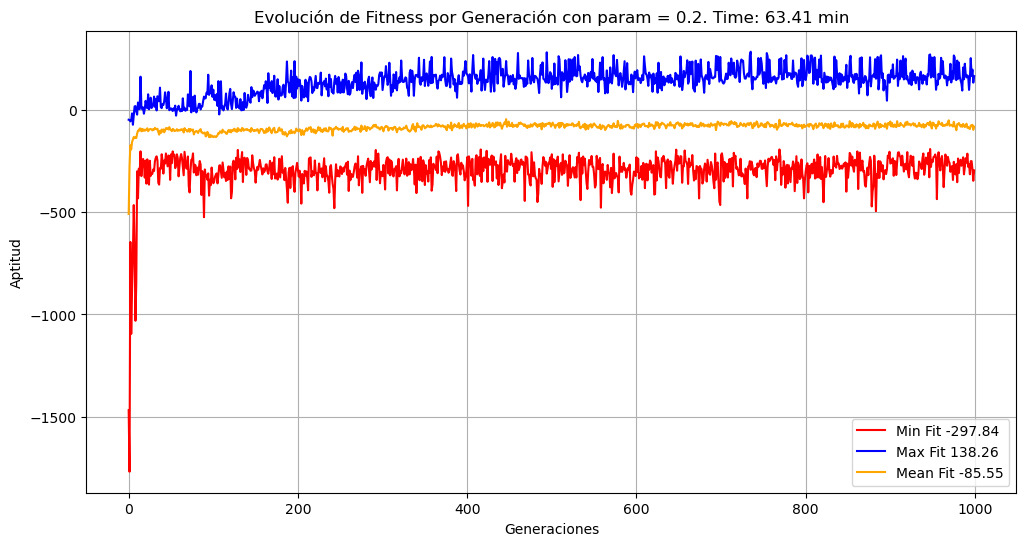

In [74]:
def visualization (generations, f_max, f_min, f_mean, time):
        
    generations = list(range(0,generations))
    plt.figure(figsize=(12,6))

    plt.plot(list(generations), list(f_min), label=f'Min Fit {np.array(f_min).mean():.2f}', color='red', linestyle='-')
    plt.plot(list(generations), list(f_max), label=f'Max Fit {np.array(f_max).mean():.2f}', color='blue', linestyle='-')
    plt.plot(list(generations), list(f_mean), label=f'Mean Fit {np.array(f_mean).mean():.2f}', color='orange', linestyle='-')

    plt.xlabel('Generaciones')
    plt.ylabel('Aptitud')
    plt.title(f'Evolución de Fitness por Generación con param = 0.2. Time: {time:.2f} min')

    plt.legend()

    plt.grid(True)
    plt.show()

visualization(len(f_maxs[0]), f_maxs[2], f_mins[2], f_means[2], execution_times[2])

---

### **Prueba 2**
- **Crossover Blending**
- Mutación gaussiana con distribución uniforme (-1,1). Probabilidad = 0.1
- Política: epsilon greedy con epsilon = 0.1
- 1000 generaciones
- Elitismo True

In [6]:
best_individuals = []
fitness_values = []
execution_time = 0

for i in range(1,2):
    print(f"Ejecución {i}")
    print("Politica: eps_greedy con 0.1. Mutate gaussiano con distribucion uniforme (-1,1). Crossover Blending")
    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    start_time = time.time()
    
    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_mean, f_min = evolve_gen(pop, rangMutacion, pmut=0.1, mutation_power=0.2, arquitecture=[8,6,4], generations=1000, T=8, trace=50, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
    
    
    best_individual = pop[0]  
    fitness_value = fitness[0]

    best_individuals.append(best_individual)
    fitness_values.append(fitness_value)

    end_time = time.time()
    execution_time = (end_time - start_time)/60

np.savetxt(f"P1_best_indvs/AG_{1000}_best.txt", best_individual)

Ejecución 1
Politica: eps_greedy con 0.1. Mutate gaussiano con distribucion uniforme (-1,1). Crossover Blending
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-1, 1), arquitecture = [8, 6, 4], generations = 1000, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 50, Mejor fitness: 55.345138844750466
Generacion: 100, Mejor fitness: 23.572932981017846
Generacion: 150, Mejor fitness: 99.42715279077781
Generacion: 200, Mejor fitness: 135.72041312056032
Generacion: 250, Mejor fitness: 136.51914131109905
Generacion: 300, Mejor fitness: 165.38504491044336
Generacion: 350, Mejor fitness: 233.65280616949963
Generacion: 400, Mejor fitness: 273.9835544534299
Generacion: 450, Mejor fitness: 225.16431458870406
Generacion: 500, Mejor fitness: 266.6710978599173
Generacion: 550, Mejor fitness: 270.2367715517226
Generacion: 600, Mejor fitness: 270.0193729156538
Generacion: 650, Mejor fitness: 263.9633345364122
Generaci

c:\Users\34627\anaconda3\Lib\site-packages\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Generacion: 850, Mejor fitness: 298.257685982475
Generacion: 900, Mejor fitness: 269.1908850799111
Generacion: 950, Mejor fitness: 269.9261829298816
Generacion: 1000, Mejor fitness: 281.37187652422807
Generacion: 1000, Mejor fitness: 281.37187652422807


In [7]:
with open("resultado_blending_2.pkl", "wb") as f:
        pickle.dump({
            "best_individuals": best_individuals,
            "fitness_values": fitness_values,
            "f_maxs": f_max,
            "f_mins": f_min,
            "f_means": f_mean,
            "execution_times": execution_time
        }, f)

In [8]:
with open("resultado_blending_2.pkl", "rb") as f:
    data = pickle.load(f)

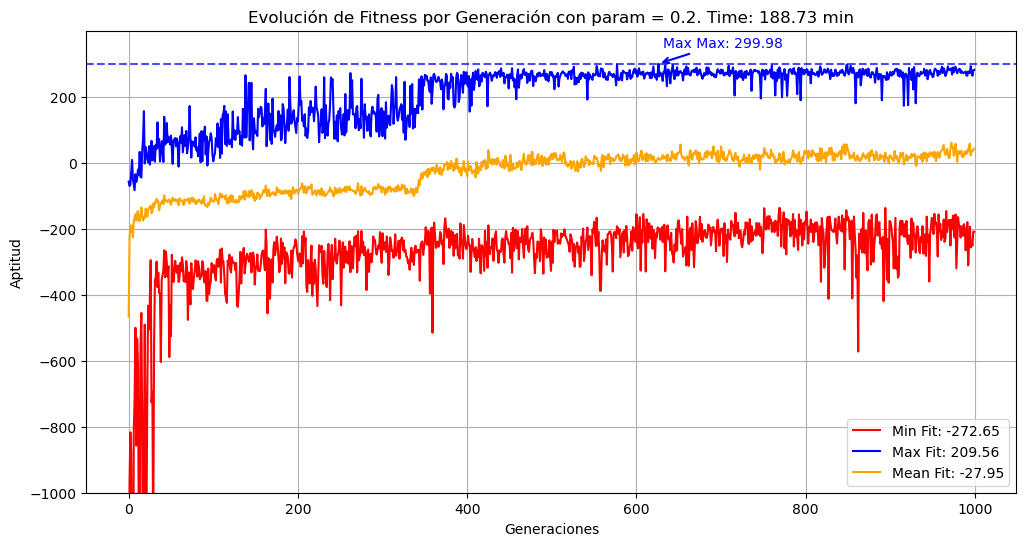

In [13]:
def visualization (generations, f_max, f_min, f_mean, time):
        
    generations = list(range(0,generations))
    plt.figure(figsize=(12,6))

    plt.plot(list(generations), list(f_min), label=f'Min Fit: {np.array(f_min).mean():.2f}', color='red', linestyle='-')
    plt.plot(list(generations), list(f_max), label=f'Max Fit: {np.array(f_max).mean():.2f}', color='blue', linestyle='-')
    plt.plot(list(generations), list(f_mean), label=f'Mean Fit: {np.array(f_mean).mean():.2f}', color='orange', linestyle='-')

    max_f_max = max(f_max)
    max_f_max_gen = generations[f_max.index(max_f_max)]
    
    plt.axhline(y=max_f_max, color='blue', linestyle='dashed', alpha=0.7, linewidth=1.5)
    plt.annotate(f'Max Max: {max_f_max:.2f}', xy=(max_f_max_gen, max_f_max),
                 xytext=(max_f_max_gen + 5, max_f_max + 50),
                 arrowprops=dict(arrowstyle='->', color='blue', linewidth=1.5),
                 fontsize=10, color='blue')
    

    plt.xlabel('Generaciones')
    plt.ylabel('Aptitud')
    plt.title(f'Evolución de Fitness por Generación con param = 0.2. Time: {time:.2f} min')

    plt.legend()

    plt.grid(True)

    plt.ylim(-1000, max(max(f_max), max(f_mean), max(f_min)) + 100)
    plt.show()

visualization(len(f_max), f_max, f_min, f_mean, execution_time)

Se prueba el mejor individuo de la última ejecución en el entorno LunarLander

In [11]:
np.savetxt(f"P1_best_indvs/AG_1000_p2.0_best.txt", best_individual)

In [28]:
test_chromosome = np.loadtxt(f"P1_best_indvs/AG_1000_p2.0_best.txt").tolist()
arquitecture = [8,6,4]
test_model = MLP(arquitecture) 
test_model.from_chromosome(test_chromosome)

num_episodes_test = 20
destiny_folder = "P1_best_indvs/videos"
test_env = gym.make("LunarLander-v3", render_mode="rgb_array")
test_env = RecordVideo(test_env, video_folder=destiny_folder, name_prefix=f"AG-1000_p2.0", episode_trigger=lambda x: x < num_episodes_test)  

def policy(observation):
    s = test_model.forward(observation)
    action = np.argmax(s)
    return action

for episode in range(num_episodes_test):
    state, _ = test_env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = policy(state)  
        next_state, reward, done, _, _ = test_env.step(action) 
        total_reward += reward
        state = next_state

        if done:
            print(f"Episode {episode}: Reward = {total_reward}")

test_env.close()

c:\Users\34627\anaconda3\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\34627\Desktop\Reinforcement-Learning-GenerativeAI\Reinforcement_Learning\P1_best_indvs\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 0: Reward = 250.79902385877335
Episode 1: Reward = 275.2412544352235
Episode 2: Reward = 218.4762091341144
Episode 3: Reward = 309.2829084653686
Episode 4: Reward = 300.4569611499254
Episode 5: Reward = 256.4251000328595
Episode 6: Reward = 264.5168545684843
Episode 7: Reward = 278.1638195447896
Episode 8: Reward = 308.93045170729175
Episode 9: Reward = 322.2520431608467
Episode 10: Reward = 274.26598024312284
Episode 11: Reward = 273.2359253660486
Episode 12: Reward = 301.04470268448864
Episode 13: Reward = 271.7555424844463
Episode 14: Reward = 287.72509330103
Episode 15: Reward = 289.79966632566646
Episode 16: Reward = 286.45512855920794
Episode 17: Reward = 295.6337622707745
Episode 18: Reward = 285.5044869092125
Episode 19: Reward = 268.1270914525729


#### **Prueba 2.1** *Ejecucion con GPU Anny*. Se puede pensar otro experimento
- **Crossover Blending**
- Mutación gaussiana con distribución uniforme. Probabilidad = 0.1
- Política: epsilon greedy con epsilon = 0.1
- 1000 generaciones
- Elitismo True

*Se puede probar otro tipo de experimento*
Se prueban rangos de mutación (-1, 1), (-0.5, 0.5), (-0.25, 0.25) y (-2, 2)

In [6]:
def mutate_gaussian_uniforme(ind, pmut, rangMut=(-1, 1)):  
    if random.random() < pmut:
        ind = [gen + random.uniform(rangMut[0], rangMut[1]) for gen in ind]
    return ind.copy()


In [7]:
def evolve_gen(pop, rangMut, pmut, mutation_power, arquitecture = [8,6,4], generations = 6000, T=2, trace=100, pcross=0.7, elitism=False, N_games=2, n_elitism=0):
    
    print(f"Parámetros: pmut = {pmut}, Rango de Mutacion = {rangMut}, arquitecture = {arquitecture}, generations = {generations}, T = {T}, pcross = {pcross}, elitism = {elitism}, N_games = {N_games}, n_elitism = {n_elitism}")
    
    max_fitness_perGeneration = []
    mean_fitness_perGeneration = []
    min_fitness_perGeneration = []

    generation = 0
    executor = get_reusable_executor(max_workers=35)

    
    while generation < generations:
        new_poblacion = []

        fitness_array = list(executor.map(run_multiple_games, pop, itertools.repeat(arquitecture), itertools.repeat(N_games)))
        generation += 1

        pop, fitness = sort_pop(pop, fitness_array)
     

        max_fitness_perGeneration.append(fitness[0])
        mean_fitness_perGeneration.append(np.array(fitness).mean())
        min_fitness_perGeneration.append(fitness[-1])

        if trace > 0 and generation % trace == 0:
            print(f"Generacion: {generation}, Mejor fitness: {fitness[0]}")
            
        if generation >= generations:
            break

        if elitism:
            new_poblacion.extend([ind.copy() for ind in pop[:n_elitism]])

        while len(new_poblacion) < len(pop):
            parent_1 = select(pop, T, fitness)
            parent_2 = select(pop, T, fitness)

            child_1, child_2 = crossover_blending(parent_1, parent_2, pcross)

            m1 = mutate_gaussian_uniforme(child_1, pmut, rangMut)
            m2 = mutate_gaussian_uniforme(child_2, pmut, rangMut)

            new_poblacion.extend([m1, m2])

        pop = new_poblacion[:len(pop)].copy()

    print(f"Generacion: {generation}, Mejor fitness: {fitness[0]}")
    
    return pop, fitness, max_fitness_perGeneration, mean_fitness_perGeneration, min_fitness_perGeneration

In [8]:
import pickle

best_individuals = []
fitness_values = []

f_maxs = []
f_mins = []
f_means = []

rangs = [(-0.25, 0.25)]

execution_times = []

for i, rang in enumerate(rangs):

    start_time = time.time()

    print(f"### Entrenamiento [{i}]. Rango uniforme de mutacion: {rang}")  

    rangMutacion = (-1, 1)
    createRang = (-5, 5)

    pop = create(createRang, arquitecture=[8,6,4]) 

    pop, fitness, f_max, f_mean, f_min = evolve_gen(pop, rang, pmut=0.1, mutation_power=0, arquitecture=[8,6,4], generations=1000, T=8, trace=200, pcross=0.7, elitism=True, N_games=3, n_elitism=5)
                 
    f_maxs.append(list(f_max))  
    f_mins.append(list(f_min))
    f_means.append(list(f_mean))

    best_individuals.append(list(pop))  
    fitness_values.append(list(fitness))  

    end_time = time.time()
    execution_times.append((end_time - start_time)/60)

    #nombre del archivo cambiado manualmente
    with open("resultados_blending_rangs_2.1.pkl", "wb") as f:
        pickle.dump({
            "best_individuals": best_individuals,
            "fitness_values": fitness_values,
            "f_maxs": f_maxs,
            "f_mins": f_mins,
            "f_means": f_means,
            "execution_times": execution_times
        }, f)

    print(f"Iteración [{i}] completada y guardada en 'resultados_blending_rangs_2.1.pkl'")


### Entrenamiento [0]. Rango uniforme de mutacion: (-0.25, 0.25)
--- Creacion de poblacion: Individuos = 100, Rango = (-5, 5)
Parámetros: pmut = 0.1, Rango de Mutacion = (-0.25, 0.25), arquitecture = [8, 6, 4], generations = 1000, T = 8, pcross = 0.7, elitism = True, N_games = 3, n_elitism = 5
Generacion: 200, Mejor fitness: 194.98946865776085
Generacion: 400, Mejor fitness: 291.36986430169003
Generacion: 600, Mejor fitness: 285.58390180944116
Generacion: 800, Mejor fitness: 291.05840740300897
Generacion: 1000, Mejor fitness: 294.269962708289
Generacion: 1000, Mejor fitness: 294.269962708289
Iteración [0] completada y guardada en 'resultados_blending_rangs_2.1.pkl'


In [ ]:
with open("resultados_blending_rangs_2.1-2_2.pkl", "rb") as f:
    data = pickle.load(f)

with open("resultados_blending_rangs_2.1-1_1.pkl", "rb") as f:
    data2 = pickle.load(f)

with open("resultados_blending_rangs-05_05.pkl", "rb") as f:
    data3 = pickle.load(f)

with open("resultados_blending_rangs_2.1-025_025.pkl", "rb") as f:
    data4 = pickle.load(f)


In [ ]:
import pickle
import matplotlib.pyplot as plt

rangs = [(-2, 2), (-1, 1), (-0.5, 0.5), (-0.25, 0.25)]

f_maxs = data["f_maxs"]
f_mins = data["f_mins"]
f_means = data["f_means"]
execution_times = data["execution_times"]

plt.figure(figsize=(14,8))
for i, f_max in enumerate(f_maxs):
    plt.plot(f_max, label=f"Param {rangs[i]} | {np.array(f_max).mean():.2f}")


plt.xlabel("Generaciones")
plt.ylabel("Fitness Máximo")
plt.title("Evolución del Fitness Máximo")
plt.legend()
plt.show()